# **Instalasi Kaggle**

Import kaggle untuk mengambil data

In [1]:
!pip install -q kaggle

Masukkan file .json yang berisikan username dan key

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farhanhamzah","key":"eb51f66ce1088b24ad1d5a4dab424e33"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

Megunduh dataset dari platform kaggle.com

In [5]:
!kaggle datasets download -d mabusalah/brent-oil-prices

  0% 0.00/36.0k [00:00<?, ?B/s]
100% 36.0k/36.0k [00:00<00:00, 31.6MB/s]


# **Import Library**

In [27]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# **Ekstraksi & Load Data**

Ekstraksi data

In [28]:
local_zip = '/content/brent-oil-prices.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Membuat dataframe

In [29]:
df=pd.read_csv('/content/BrentOilPrices.csv')
df

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63
...,...,...
8549,"Jan 19, 2021",55.38
8550,"Jan 20, 2021",55.66
8551,"Jan 21, 2021",55.68
8552,"Jan 22, 2021",55.22


# **Informasi Data**

Memeriksa informasi data

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8554 entries, 0 to 8553
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8554 non-null   object 
 1   Price   8554 non-null   float64
dtypes: float64(1), object(1)
memory usage: 133.8+ KB


Cek apakah ada data yang kosong

In [31]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

Deskripsi data

In [32]:
df.describe()

,Price
count,8554.000000
mean,46.352962
std,32.165282
min,9.100000
25%,18.850000
50%,33.240000
75%,66.210000
max,143.950000


# **Data Analysis**

Mengganti format data "Date" menggunakan to_datetime yang ada pada library pandas. Lalu menyorting data "Date" dari tahun 1987 ke 2021 menggunakan sort_values yang juga ada pada library pandas. 

In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'])
print(df.dtypes)
df

Date     datetime64[ns]
Price           float64
dtype: object


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
8549,2021-01-19,55.38
8550,2021-01-20,55.66
8551,2021-01-21,55.68
8552,2021-01-22,55.22


Menghilangkan kolom nomor rows menggunakan drop

In [34]:
df.index = df['Date']
df = df.drop(['Date'], axis=1)
df

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2021-01-19,55.38
2021-01-20,55.66
2021-01-21,55.68


Membuat plot harga minyak dari tahun ke tahun menggunakan fungsi plot dari library matplotlib.

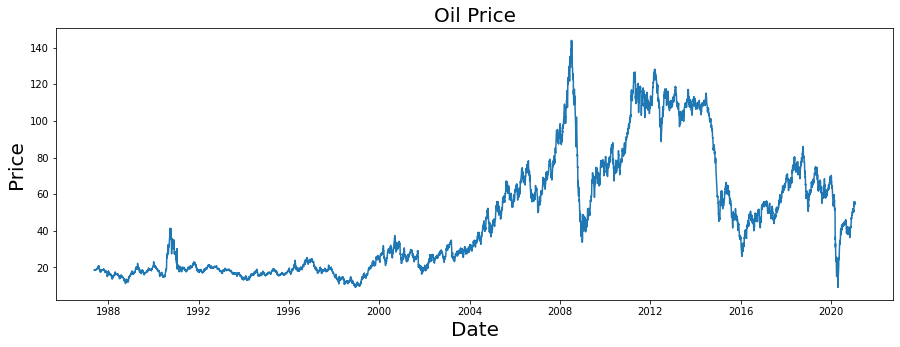

In [35]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Oil Price', fontsize=20)
plt.show()

# **Scaling Data**

Melakaukan preprocessing data menggunakan MinMaxScaler yang berfungsi untuk mengubah data berada di rentang 0 sampai 1

In [38]:
mm_scaler = preprocessing.MinMaxScaler()
df = mm_scaler.fit_transform(df)
train_data, test_data = df[0:int(len(df)*0.8), :], df[int(len(df)*0.8):len(df), :]
mm_scaler.transform(test_data)

array([[0.73919169],
       [0.74727475],
       [0.74631072],
       ...,
       [0.34542084],
       [0.34200964],
       [0.34364108]])

Score mae

In [39]:
MAE_SCORE = (train_data.max() - train_data.min()) * 10/100
print(MAE_SCORE)

0.1


Membuat fungsi dataset_preparation untuk menyiapkan dataset

In [40]:
def dataset_preparation(dataset, window):
    df = []
    label = []

    for i in range(len(dataset) - window - 1):
        data = dataset[i:(i + window), 0]
        df.append(data)
        label.append(dataset[i+window,0])
    return np.array(df), np.array(label)

x_train, y_train = dataset_preparation(train_data,80)
x_test, y_test = dataset_preparation(test_data,80)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_train.shape[1],1))

In [41]:
print('trainX shape == {}.'.format(x_train.shape))
print('trainY shape == {}.'.format(y_train.shape))
print('testX shape == {}.'.format(x_test.shape))
print('testY shape == {}.'.format(y_test.shape))

trainX shape == (6762, 80, 1).
trainY shape == (6762,).
testX shape == (1630, 80, 1).
testY shape == (1630,).


# **Modeling**

Untuk arsitektur model gunakan 1 buah layer LSTM

In [42]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(60, input_shape = (x_train.shape[1], 1)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(1)
])

Membuat callback function

In [43]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.0005 and logs.get('val_loss') <0.0005):
      print("\ntraining berhenti")
      self.model.stop_training = True
callbacks = myCallback()

Pada optimizer menggunakan parameter adam seperti di bawah. Loss function yang dapat dicoba untuk ini adalah MSE (Mean Squared Error).

In [44]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam', 
    metrics=["mae"])

Hasil dari pelatihan model adalah sebagai berikut yang menunjukkan model memiliki loss yang relatif rendah.

In [45]:
hist = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_train, y_train),
    epochs=15,
    callbacks=[callbacks],
    batch_size=64,
    verbose=1,)

Epoch 1/15
106/106 [==============================] - 9s 65ms/step - loss: 0.0105 - mae: 0.0529 - val_loss: 3.3785e-04 - val_mae: 0.0130
Epoch 2/15
106/106 [==============================] - 6s 61ms/step - loss: 0.0013 - mae: 0.0219 - val_loss: 3.0596e-04 - val_mae: 0.0117
Epoch 3/15
106/106 [==============================] - 7s 63ms/step - loss: 0.0010 - mae: 0.0195 - val_loss: 3.1855e-04 - val_mae: 0.0113
Epoch 4/15
106/106 [==============================] - 7s 65ms/step - loss: 9.2695e-04 - mae: 0.0185 - val_loss: 2.5091e-04 - val_mae: 0.0107
Epoch 5/15
106/106 [==============================] - 7s 65ms/step - loss: 8.0890e-04 - mae: 0.0173 - val_loss: 2.3237e-04 - val_mae: 0.0101
Epoch 6/15
106/106 [==============================] - 7s 62ms/step - loss: 8.1282e-04 - mae: 0.0172 - val_loss: 2.4057e-04 - val_mae: 0.0102
Epoch 7/15
106/106 [==============================] - 7s 64ms/step - loss: 8.0625e-04 - mae: 0.0169 - val_loss: 2.2061e-04 - val_mae: 0.0096
Epoch 8/15
106/106 [=====

Menampilkan plot loss

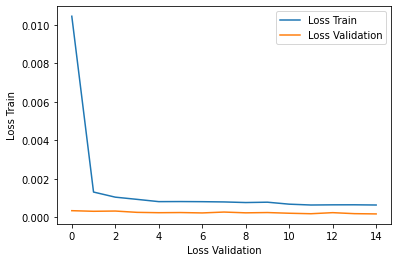

In [46]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss Train')
plt.xlabel('Loss Validation')
plt.legend(['Loss Train', 'Loss Validation'], loc='upper right')
plt.show()

Menampilkan plot mae

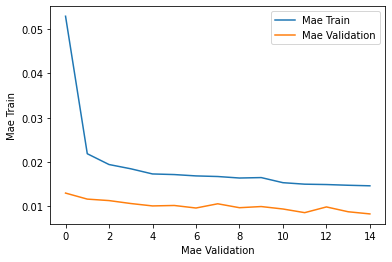

In [47]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.ylabel('Mae Train')
plt.xlabel('Mae Validation')
plt.legend(['Mae Train', 'Mae Validation'], loc='upper right')
plt.show()

Memprediksi tiap step menggunakan predict yang ada pada library sklearn

In [48]:
predict_model_test = model.predict(x_test)
predict_model_test = mm_scaler.inverse_transform(predict_model_test)
actual_model_test = mm_scaler.inverse_transform([y_test])

Membandingkan grafik prediksi dan yang sebenarnya

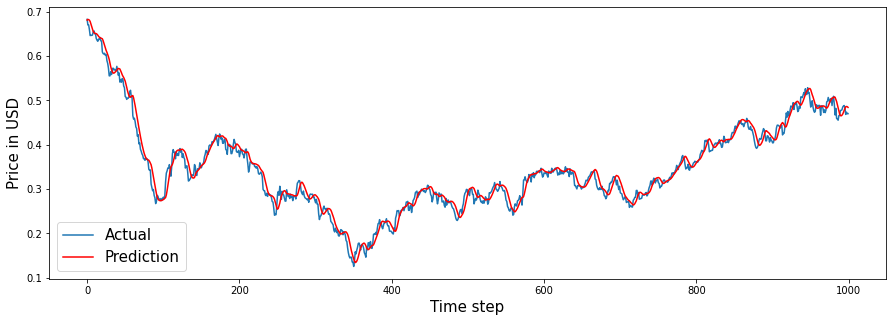

In [49]:
plot=[i for i in range(1000)]
plt.figure(figsize=(15,5))
plt.plot(plot, actual_model_test[0][:1000])
plt.plot(plot, predict_model_test[:,0][:1000], 'red')
plt.ylabel('Price in USD', size=15)
plt.xlabel('Time step', size=15)
plt.legend(["Actual", "Prediction"], fontsize=15, loc='lower left')
plt.show();

Dari grafik di atas dapat dilihat bahwa prediksi yang diasilkan menyerupai aslinya.